In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

2023-08-14 16:05:54.944671: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-14 16:05:55.911465: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
splits = ['train[:70%]', 'train[70%:]']

(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers',
    split=splits,
    with_info=True,
    as_supervised=True,
)

num_classes = dataset_info.features['label'].num_classes

num_training_examples = 0
num_validation_examples = 0

for example in training_set:
  num_training_examples += 1

for example in validation_set:
  num_validation_examples += 1

print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

2023-08-14 16:05:57.627951: W tensorflow/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /home/amira/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


2023-08-14 16:09:28.315585: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-14 16:09:28.515547: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-14 16:09:28.516143: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Total Number of Classes: 5
Total Number of Training Images: 2569
Total Number of Validation Images: 1101 



In [3]:
for i, example in enumerate(training_set.take(5)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (317, 500, 3) label: 3


2023-08-14 16:09:30.258391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2]
	 [[{{node Placeholder/_0}}]]
2023-08-14 16:09:30.258895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [2]
	 [[{{node Placeholder/_4}}]]


In [4]:
num_training_examples

2569

In [8]:
IMAGE_RES = 224

def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
    return image, label

BATCH_SIZE = 32

train_batches = training_set.shuffle(num_training_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [11]:
URL = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'
feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))

feature_extractor.trainable = False

In [14]:
model = tf.keras.Sequential([
    feature_extractor,
    layers.Dense(num_classes)
])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense_1 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [17]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 22s 259ms/step - loss: 0.2038 - accuracy: 0.9389 - val_loss: 0.3068 - val_accuracy: 0.8974
Epoch 2/6
81/81 [==============================] - 21s 256ms/step - loss: 0.1678 - accuracy: 0.9529 - val_loss: 0.2985 - val_accuracy: 0.9037
Epoch 3/6
81/81 [==============================] - 21s 256ms/step - loss: 0.1448 - accuracy: 0.9630 - val_loss: 0.2975 - val_accuracy: 0.9010
Epoch 4/6
81/81 [==============================] - 21s 255ms/step - loss: 0.1267 - accuracy: 0.9708 - val_loss: 0.2974 - val_accuracy: 0.9046
Epoch 5/6
81/81 [==============================] - 21s 256ms/step - loss: 0.1128 - accuracy: 0.9724 - val_loss: 0.2878 - val_accuracy: 0.9092
Epoch 6/6
81/81 [==============================] - 21s 257ms/step - loss: 0.1025 - accuracy: 0.9766 - val_loss: 0.2842 - val_accuracy: 0.9101


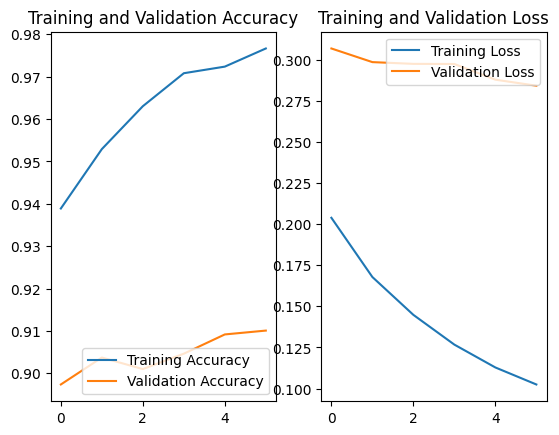

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
class_names = np.array(dataset_info.features['label'].names)
class_names

array(['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'],
      dtype='<U10')

In [22]:
image_batch, label_batch = next(iter(train_batches))


image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)

1/1 [==============================] - 0s 386ms/step
['tulips' 'dandelion' 'dandelion' 'dandelion' 'sunflowers' 'dandelion'
 'dandelion' 'dandelion' 'daisy' 'daisy' 'daisy' 'tulips' 'dandelion'
 'dandelion' 'dandelion' 'dandelion' 'daisy' 'dandelion' 'dandelion'
 'dandelion' 'sunflowers' 'dandelion' 'dandelion' 'sunflowers'
 'sunflowers' 'sunflowers' 'dandelion' 'sunflowers' 'daisy' 'tulips'
 'daisy' 'dandelion']


In [23]:
print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:            [2 0 0 0 3 0 0 0 1 1 1 2 0 0 0 0 1 0 0 0 3 0 0 3 3 3 0 3 1 2 1 0]
Predicted labels:  [2 0 0 0 3 0 0 0 1 1 1 2 0 0 0 0 1 0 0 0 3 0 0 3 3 3 0 3 1 2 1 0]


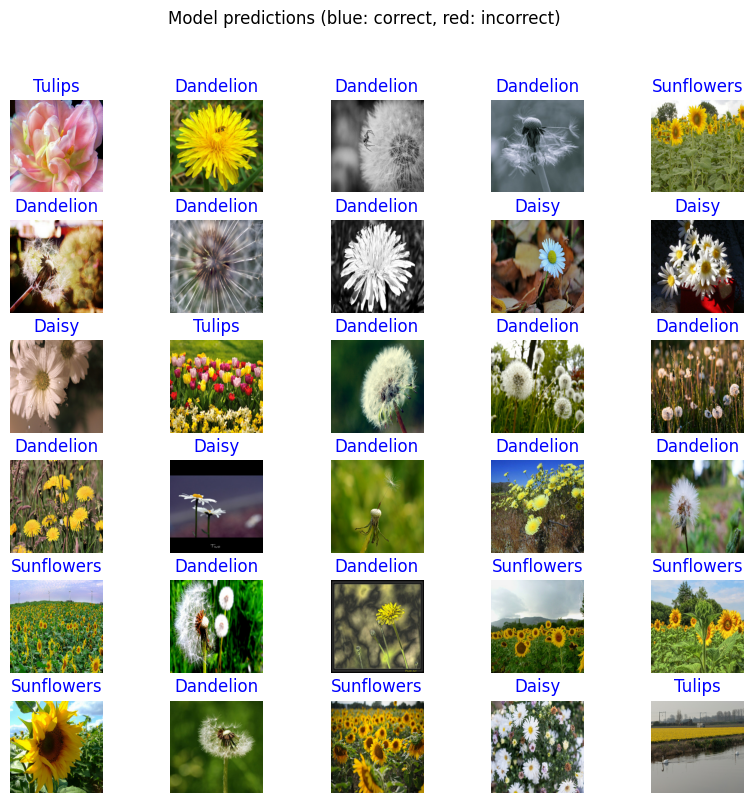

In [24]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

# Inception

In [26]:
URL_inception = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor_inception = hub.KerasLayer(URL_inception,
  input_shape=(IMAGE_RES, IMAGE_RES, 3),
  trainable=False)

model_inception = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(num_classes)
])

model_inception.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense_2 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [28]:
model_inception.compile(
  optimizer='adam', 
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6

history = model_inception.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 22s 259ms/step - loss: 0.3922 - accuracy: 0.8665 - val_loss: 0.3354 - val_accuracy: 0.8910
Epoch 2/6
81/81 [==============================] - 21s 254ms/step - loss: 0.2899 - accuracy: 0.9066 - val_loss: 0.3028 - val_accuracy: 0.9046
Epoch 3/6
81/81 [==============================] - 21s 254ms/step - loss: 0.2399 - accuracy: 0.9257 - val_loss: 0.2883 - val_accuracy: 0.9037
Epoch 4/6
81/81 [==============================] - 21s 255ms/step - loss: 0.2064 - accuracy: 0.9428 - val_loss: 0.3088 - val_accuracy: 0.8974
Epoch 5/6
81/81 [==============================] - 21s 256ms/step - loss: 0.1771 - accuracy: 0.9529 - val_loss: 0.2754 - val_accuracy: 0.9101
Epoch 6/6
81/81 [==============================] - 21s 256ms/step - loss: 0.1545 - accuracy: 0.9615 - val_loss: 0.2713 - val_accuracy: 0.9119


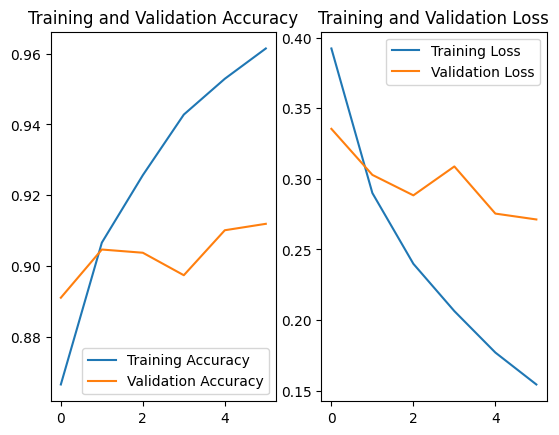

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [30]:
predicted_batch = model_inception.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)

1/1 [==============================] - 0s 362ms/step
['tulips' 'dandelion' 'dandelion' 'dandelion' 'sunflowers' 'dandelion'
 'dandelion' 'dandelion' 'daisy' 'daisy' 'daisy' 'tulips' 'dandelion'
 'dandelion' 'dandelion' 'dandelion' 'daisy' 'dandelion' 'sunflowers'
 'dandelion' 'sunflowers' 'dandelion' 'dandelion' 'sunflowers'
 'sunflowers' 'sunflowers' 'dandelion' 'sunflowers' 'daisy' 'tulips'
 'daisy' 'dandelion']


Labels:            [2 0 0 0 3 0 0 0 1 1 1 2 0 0 0 0 1 0 0 0 3 0 0 3 3 3 0 3 1 2 1 0]
Predicted labels:  [2 0 0 0 3 0 0 0 1 1 1 2 0 0 0 0 1 0 3 0 3 0 0 3 3 3 0 3 1 2 1 0]


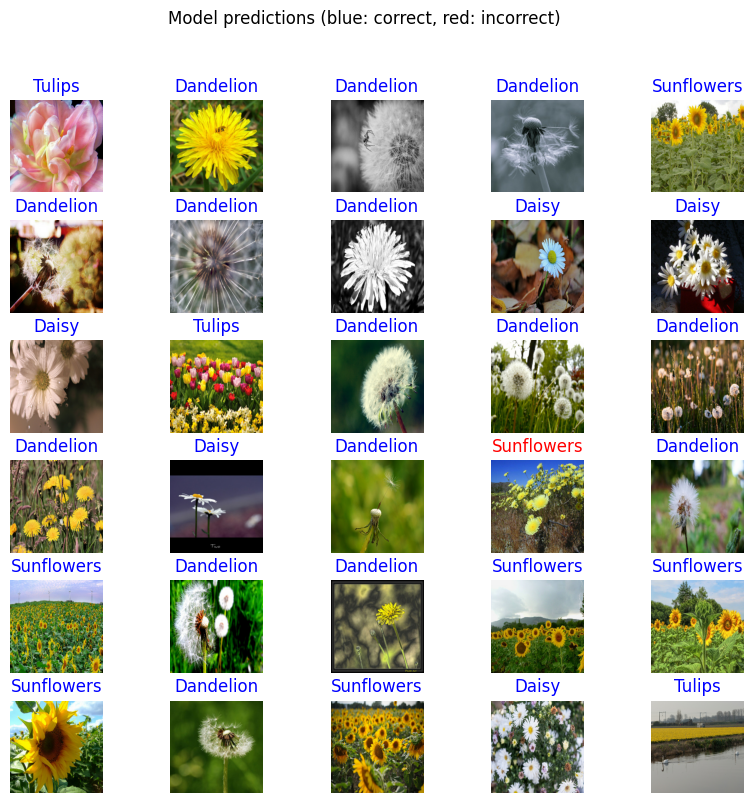

In [32]:
print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")